In [1]:
import pandas  as pd
from sklearn.feature_selection import f_regression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest
from smt.surrogate_models import RBF,KRG,LS
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, Matern
from sklearn.gaussian_process import kernels
import copy
from collections import Counter
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, KFold,GridSearchCV
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold

In [2]:
def getData():
    data1 = pd.read_csv('./data/data_1110.csv', na_values={'dist_out_in':0,'dist_out_mid':0,'dist_mid_in':0,'dist_in_hard':0})
    data2 = pd.read_csv('./data/data_1205.csv',na_values={'dist_out_in':0,'dist_out_mid':0,'dist_mid_in':0,'dist_in_hard':0})
    raw_data = pd.concat([data1,data2], axis=0).iloc[:,1:].reset_index(drop=True)
    return raw_data.iloc[:,:-1], raw_data['HIC15']

In [3]:
raw_data, raw_label = getData()

In [4]:
# raw_data[['JR_X','JR_Z','JR_Z']]

In [5]:
raw_data.shape

(357, 58)

# 数据预处理

## 缺失处理和方差筛选

In [6]:
def imputerVar(data, label, threshold=1):
    '''缺失处理和方差筛选'''
    data = pd.DataFrame(SimpleImputer().fit_transform(data),columns=data.columns)
    varModel = VarianceThreshold(threshold=threshold).fit(data)
#     print(data.shape)
    print(set(varModel.feature_names_in_)-set(varModel.get_feature_names_out()))
    data = varModel.transform(data)
    data = pd.DataFrame(data, columns=varModel.get_feature_names_out())
    return data, label

In [7]:
data, label = imputerVar(raw_data, raw_label, 0)

{'delta_mid_R', 'T_in', 'T_out', 'JR_Y', 'T_S_mid_F', 'T_S_in', 'Y_S_mid_F', 'delta_out', 'JL_Y', 'Y_S_out', 'Y_S_in', 'JR_X', 'T_S_out', 'JL_X', 'Y_S_mid_R', 'T_mid_R', 'T_S_mid_R', 'head_V', 'delta_in', 'JR_Z', 'delta_mid_F', 'T_mid_F'}


In [8]:
data.shape

(357, 36)

## 异常值检测

In [9]:
def solveoutliers(flag, data, label, contamination):
    '''是否处理异常值'''
    def isoForest(data, label, contamination=0.1):
        '''孤立森林去除异常值'''
        IsoData = copy.deepcopy(data)
        clf = IsolationForest(max_samples='auto', random_state=0,max_features=1,contamination=contamination).fit(IsoData)
        myIsoDataIndex = clf.predict(IsoData)
        print(Counter(myIsoDataIndex))
        data_ = IsoData[myIsoDataIndex==1]
        label_ = label[myIsoDataIndex==1]
        iso_data = IsoData[myIsoDataIndex==-1]
        iso_label = label[myIsoDataIndex==-1]
        pd.concat([iso_data,iso_label], axis=1).to_csv('./data/significantSample.csv')
        return data_, label_, iso_data, iso_label
    if flag:
        return isoForest(data, label, contamination)
    return data, label, _, _

In [10]:
data, label, iso_data, iso_label = solveoutliers(False, data, label, 0.05)

# 数据标准化与拆分

In [11]:
def stdSplitData(data, label):
    '''数据标准化，然后拆分数据集'''
    data = pd.DataFrame(preprocessing.StandardScaler().fit_transform(data), columns=data.columns)
    x_train,x_test,y_train,y_test = train_test_split(data,label,test_size=0.1,random_state=420)
    return x_train,x_test,y_train,y_test
x_train,x_test,y_train,y_test = stdSplitData(data, label)

In [12]:
x_train.shape

(321, 36)

# 结果可视化

In [13]:
# 可视化预测结果和真是结果
def plotOutputs(y_test, y_pred, alg_name,r2):
    # Plot outputs
    plt.figure(figsize=(12,6))
    x = range(y_test.shape[0])
    l1 = plt.plot(x, y_test, 'o-', color="red",  linewidth=1, linestyle='-', label='y_true')
    # 使用一个列表（temp）来存储每个点的坐标
    y_test_value = [list(y_test)[i] for i in range(len(x))]
    # 有多少个点就循环多少次
    for i in range(len(x)):
        plt.annotate(y_test_value[i], xy=(x[i], y_test_value[i]),
                     xytext=(x[i] + 0.01, y_test_value[i] + 0.01), color='red')  # 这里xy是需要标记的坐标，xytext是对应的标签坐标
    l2 = plt.plot(x, y_pred, 'o-', color="blue", linewidth=1, linestyle='-.', label='y_pred')
    for i in range(len(x)):
        plt.annotate(np.round(y_pred[i],4), xy=(x[i], y_pred[i]),
                     xytext=(x[i] - 0.1, y_pred[i] - 0.1), color='blue')  # 这里xy是需要标记的坐标，xytext是对应的标签坐标
    plt.xlabel('预测点的索引')
    plt.ylabel('y值')
    plt.xticks(x)
    plt.yticks(range(int(min(y_test)), int(max(y_test)),80))
    plt.legend()
    plt.title(f'{alg_name}测试集上预测值和真实值对比图,test_r2={r2}')
    plt.show()

In [14]:
def cvR2ScoreSingleParam(data, label, model, param_grid, pname, text=False):
    '''R2随着某个参数的变化图'''
    n_folds=10
    cv = KFold(n_splits=n_folds)
    grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            return_train_score=True,
            cv=cv,
            scoring='r2'
        ).fit(data, label)

    scores = np.nan_to_num(grid_search.cv_results_["mean_test_score"])
    scores_std = grid_search.cv_results_["std_test_score"]
    plt.figure().set_size_inches(8, 6)
    if text==True:
        names = param_grid[pname]
        x = range(len(param_grid[pname]))
    else:
        x = param_grid[pname]
    
    plt.plot(x, scores)

    std_error = scores_std / np.sqrt(n_folds)

    plt.plot(x, scores + std_error, "b--")
    plt.plot(x, scores - std_error, "b--")

    # alpha=0.2 controls the translucency of the fill color
    plt.fill_between(x, scores + std_error, scores - std_error, alpha=0.2)
    plt.title('交叉验证的R2分数随着参数'+pname+'变化情况')
    if text==True:
        plt.xticks(x,names,rotation = 45)
        pvalue = names[list(scores).index(np.max(scores))]
    else:
        pvalue = round(x[list(scores).index(np.max(scores))],4)
    t = f'r2={np.max(scores).round(4)},{pname}={pvalue}'
    plt.axhline(np.max(scores), linestyle="-", color="r", label=t)
    plt.axhline(0, linestyle="-", color="b",label='r2=0')
    plt.ylabel("CV score +/- std error")
    plt.xlabel(pname)
    plt.xlim([x[0], x[-1]])
    plt.legend(loc='best')
    plt.show()

# 创建模型

In [15]:
def create_ml_model(model, alg_name):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    r2 = r2_score(y_test, y_pred).round(3)
    plotOutputs(y_test, y_pred, alg_name,r2)
    return model

# 线性回归模型

C:\Users\414520\AppData\Local\Temp\ipykernel_21976\4095759760.py:6: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  l1 = plt.plot(x, y_test, 'o-', color="red",  linewidth=1, linestyle='-', label='y_true')
C:\Users\414520\AppData\Local\Temp\ipykernel_21976\4095759760.py:13: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  l2 = plt.plot(x, y_pred, 'o-', color="blue", linewidth=1, linestyle='-.', label='y_pred')


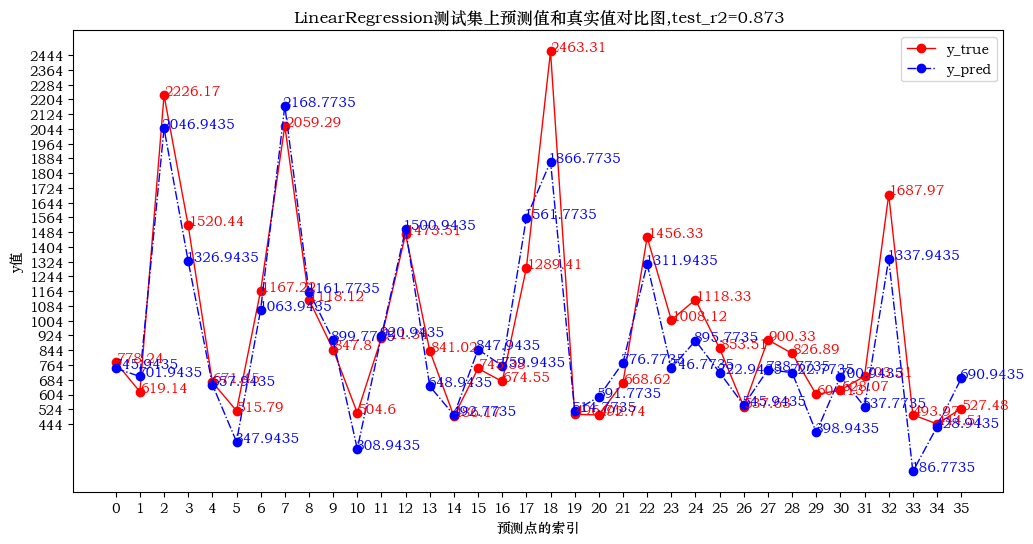

In [16]:
model = LinearRegression()
LinearModel = create_ml_model(model, 'LinearRegression')

# GaussianProcessRegressor

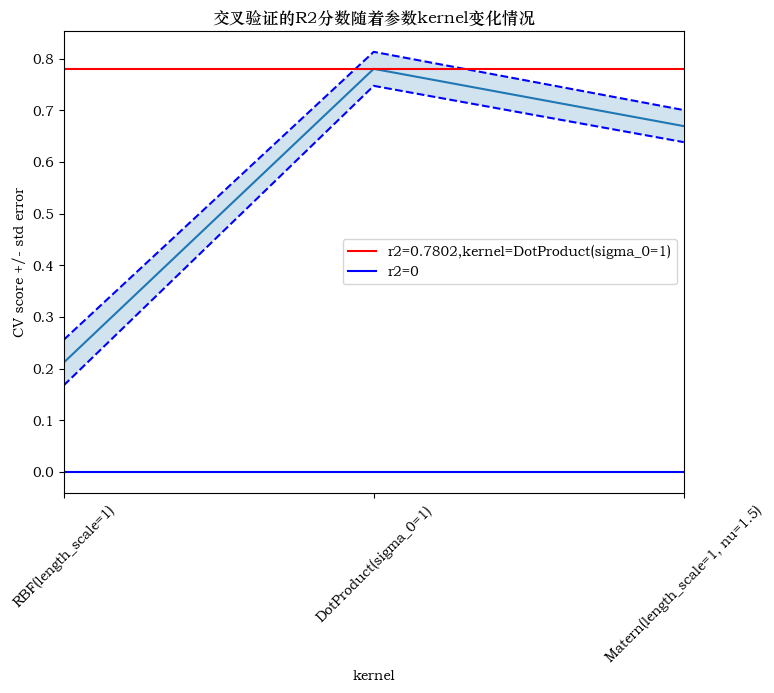

In [17]:
# 网格搜索计算的是均值
param_grid={'kernel':[kernels.RBF(),DotProduct(), Matern()]}
sm = GaussianProcessRegressor()
cvR2ScoreSingleParam(x_train,y_train, sm, param_grid, 'kernel', text=True)

C:\Users\414520\AppData\Local\Temp\ipykernel_21976\4095759760.py:6: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  l1 = plt.plot(x, y_test, 'o-', color="red",  linewidth=1, linestyle='-', label='y_true')
C:\Users\414520\AppData\Local\Temp\ipykernel_21976\4095759760.py:13: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  l2 = plt.plot(x, y_pred, 'o-', color="blue", linewidth=1, linestyle='-.', label='y_pred')


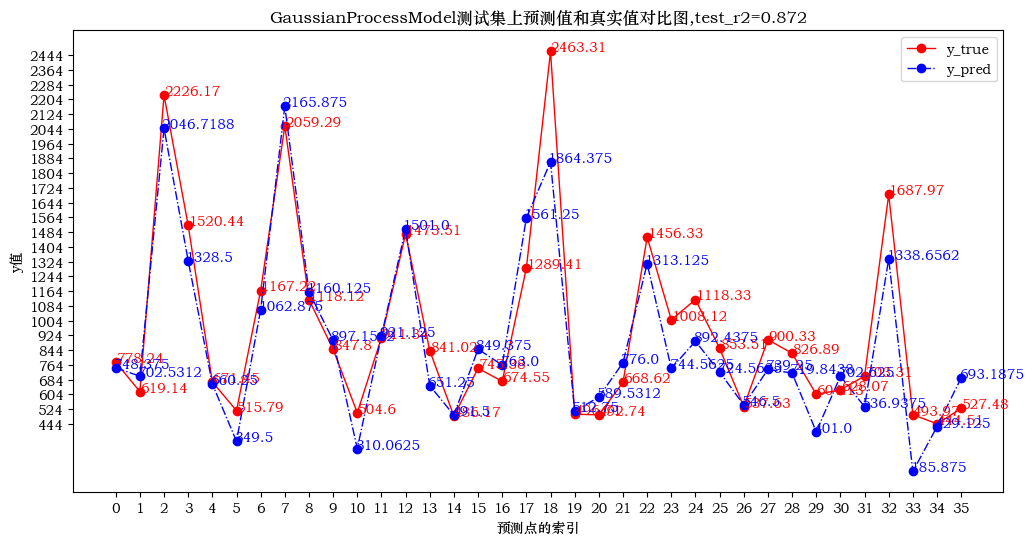

In [18]:
GaussianProcessModel = GaussianProcessRegressor(random_state=0, kernel = DotProduct())
GaussianProcessRegressor = create_ml_model(GaussianProcessModel, 'GaussianProcessModel')

## SVM

C:\Users\414520\AppData\Local\Temp\ipykernel_21976\4095759760.py:6: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  l1 = plt.plot(x, y_test, 'o-', color="red",  linewidth=1, linestyle='-', label='y_true')
C:\Users\414520\AppData\Local\Temp\ipykernel_21976\4095759760.py:13: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  l2 = plt.plot(x, y_pred, 'o-', color="blue", linewidth=1, linestyle='-.', label='y_pred')


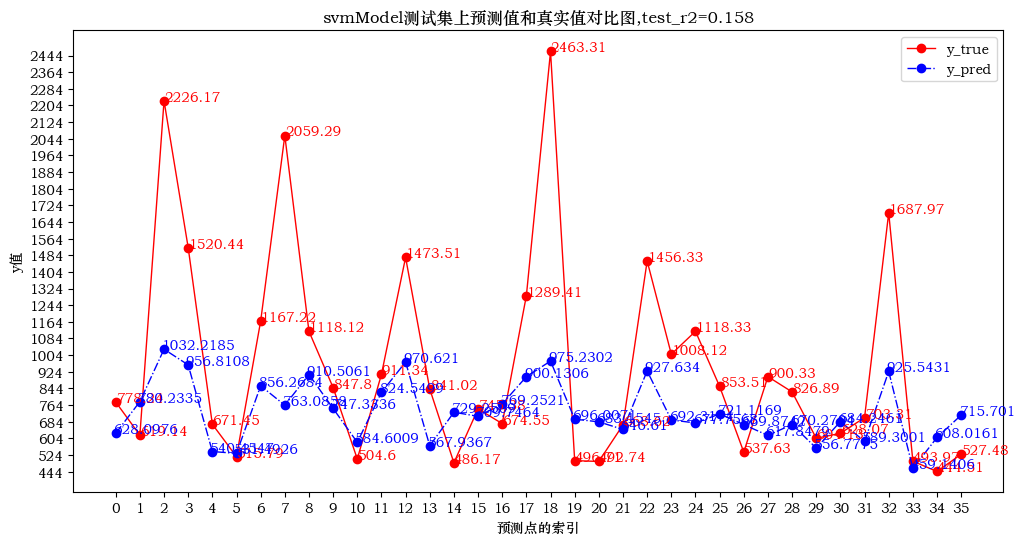

In [19]:
# {'linear', 'poly', 'rbf', 'sigmoid'}
svmModel = svm.SVR(kernel='linear',degree=3)
svmModel = create_ml_model(svmModel, 'svmModel')

# KRG

In [20]:
def create_rbf_model(sm, alg_name):
    sm.set_training_values(x_train.values, y_train.values)
    sm.train()
    y_pred = sm.predict_values(x_test.values).squeeze(axis=1)
    r2 = r2_score(y_test, y_pred).round(3)
    plotOutputs(y_test, y_pred, alg_name,r2)
    return sm

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 321
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec): 194.4300230
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 36
   
   Predicting ...
   Predicting - done. Time (sec):  0.0792267
   
   Prediction time/pt. (sec) :  0.0022007
   


C:\Users\414520\AppData\Local\Temp\ipykernel_21976\4095759760.py:6: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  l1 = plt.plot(x, y_test, 'o-', color="red",  linewidth=1, linestyle='-', label='y_true')
C:\Users\414520\AppData\Local\Temp\ipykernel_21976\4095759760.py:13: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  l2 = plt.plot(x, y_pred, 'o-', color="blue", linewidth=1, linestyle='-.', label='y_pred')


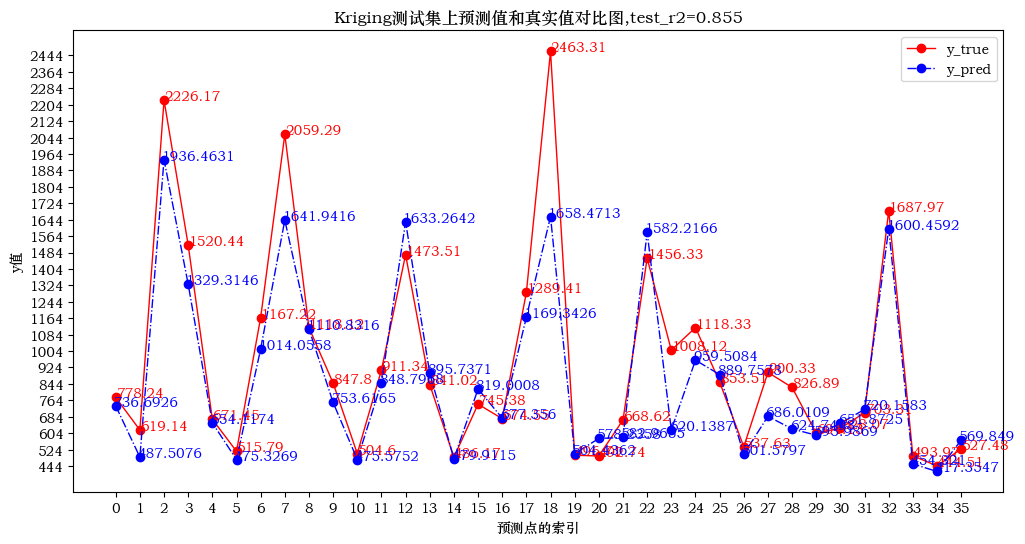

In [21]:
sm = KRG(corr='matern32',poly='constant',print_global=True)
Kriging_model = create_rbf_model(sm, 'Kriging')

# 随机森林

C:\Users\414520\AppData\Local\Temp\ipykernel_21976\4095759760.py:6: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  l1 = plt.plot(x, y_test, 'o-', color="red",  linewidth=1, linestyle='-', label='y_true')
C:\Users\414520\AppData\Local\Temp\ipykernel_21976\4095759760.py:13: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  l2 = plt.plot(x, y_pred, 'o-', color="blue", linewidth=1, linestyle='-.', label='y_pred')


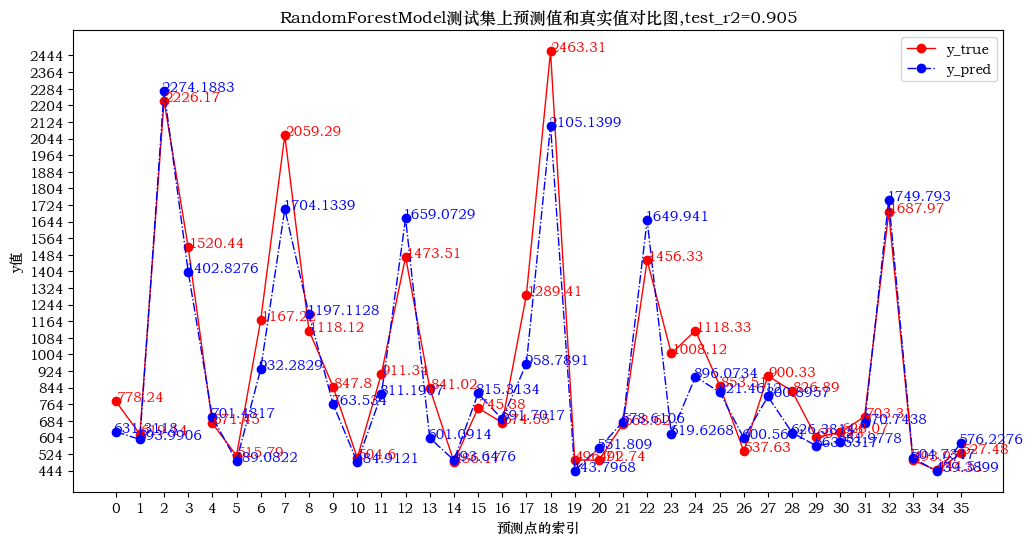

RandomForestRegressor()

In [22]:
# n_estimators=31,max_depth=6,random_state=1
RandomForestModel = RandomForestRegressor().fit( x_train, y_train)
y_pred = RandomForestModel.predict(x_test)
create_ml_model(RandomForestModel, 'RandomForestModel')

In [23]:
sorted(zip(RandomForestModel.feature_names_in_,RandomForestModel.feature_importances_), key=lambda x:x[1], reverse=True)

[('point_Z', 0.30510458577961985),
 ('dist_in_hard', 0.2286165060985621),
 ('dist_out_in', 0.12492196705199979),
 ('bonnet_YR', 0.053747203853290355),
 ('Izz', 0.0493269663353343),
 ('bonnet_YL', 0.042338238483678854),
 ('bonnet_A', 0.03596189778647706),
 ('point_Y', 0.03316076775808297),
 ('Ixx', 0.032843343570408884),
 ('Iyy', 0.031293861109324146),
 ('bonnet_XR', 0.02815955348615405),
 ('bonnet_XF', 0.01784608988679731),
 ('point_X', 0.006346140926561933),
 ('head_A', 0.004496808838389884),
 ('dist_mid_in', 0.0015851811515978028),
 ('dist_out_mid', 0.001098508971709545),
 ('B_LF_Y', 0.0003681383381031833),
 ('head_M', 0.0003111795147698212),
 ('B_RF_Z', 0.00024336575063033043),
 ('LL_X', 0.00022916180012630999),
 ('LR_Z', 0.0002234731573858294),
 ('B_RR_Y', 0.00018700984709532653),
 ('B_RR_X', 0.00016339475734144176),
 ('B_LR_X', 0.00015046905662207614),
 ('LL_Z', 0.00014645135356783527),
 ('B_LF_Z', 0.00014397006606391402),
 ('LL_Y', 0.000130251226360669),
 ('LR_X', 0.0001247933257

# 深度学习

In [24]:
'''
@File  :deeplearn_model2.py
@Author:SunNuan
@Date  :2023/12/17 11:48
@Desc  :
'''
from os.path import join

import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.model_selection import train_test_split
from torch import nn



import os
import pandas as pd
from tensorboardX import SummaryWriter
import torch
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

C:\Users\414520\AppData\Roaming\Python\Python311\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] 找不到指定的程序。'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [25]:
# train_data, test_data = train_test_split(pd.read_csv('./data/stdData.csv'),
#                                          test_size=0.1, random_state=1)
train_data = pd.concat([x_train, y_train],axis=1)
test_data = pd.concat([x_test, y_test],axis=1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [26]:
train_data.shape

(321, 37)

In [27]:
class CustomDataset(Dataset):
    def __init__(self, raw_data, transform=None, target_transform=None):
        self.raw_data = raw_data.values
        self.data = self.raw_data[:,:-1]
        self.target = self.raw_data[:,-1]
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        data = self.data[idx]
        label = self.target[idx]
        if self.transform:
            data = self.transform(data)
        if self.target_transform:
            label = self.target_transform(label)
        return data, label


train_data = CustomDataset(train_data)
test_data = CustomDataset(test_data)

train_dataloader = DataLoader(train_data,
                              batch_size=16,
                              shuffle=True,
                              num_workers=0)
test_dataloader = DataLoader(test_data,
                              batch_size=16,
                              shuffle=False,
                              num_workers=0)

In [28]:
class NetModel(nn.Module):
    def __init__(self, out_node):
        super(NetModel, self).__init__()
        self.linears = [36, 48, 16, 8, 1]
        for i in range(len(self.linears)-1):
            setattr(self, 'linear{}'.format(i), nn.Linear(self.linears[i], self.linears[i + 1]))
            nn.init.xavier_uniform_(eval('self.linear{}'.format(i)).weight)
            nn.init.zeros_(eval('self.linear{}'.format(i)).bias)
        # self.hid1 = nn.Linear(36, 48)
        # nn.init.xavier_uniform_(self.hid1.weight)
        # nn.init.zeros_(self.hid1.bias)
        # self.hid2 = nn.Linear(48,16)
        # nn.init.xavier_uniform_(self.hid2.weight)
        # nn.init.zeros_(self.hid2.bias)
        # self.oupt = nn.Linear(16, out_node)
        # nn.init.xavier_uniform_(self.oupt.weight)
        # nn.init.zeros_(self.oupt.bias)

    def forward(self, x):
        x = x.to(torch.float32)
        for i in range(len(self.linears) - 1):
            x = getattr(self, 'linear{}'.format(i))(x)
            # x = F.relu(getattr(self, 'norm{}'.format(i))(x))
        # x = x.to(torch.float32)
        # # z = torch.tanh(self.hid1(x))
        # x = self.hid1(x)
        # # z = torch.tanh(self.hid2(z))
        # x = self.hid2(x)
        # x = self.oupt(x)
        return x

In [29]:
class Writer():
    def __init__(self):
        self.display = SummaryWriter()

    # 可视化预测结果和真是结果
    def plotOutputs(self, y_test, y_pred, alg_name, r2):
        # Plot outputs
        plt.figure(figsize=(12, 6))
        x = range(len(y_test))
        l1 = plt.plot(x, y_test, 'o-', color="red", linewidth=1, linestyle='-', label='y_true')
        # 使用一个列表（temp）来存储每个点的坐标
        y_test_value = [list(y_test)[i] for i in range(len(x))]
        # 有多少个点就循环多少次
        for i in range(len(x)):
            plt.annotate(y_test_value[i], xy=(x[i], y_test_value[i]),
                         xytext=(x[i] + 0.01, y_test_value[i] + 0.01), color='red')  # 这里xy是需要标记的坐标，xytext是对应的标签坐标
        l2 = plt.plot(x, y_pred, 'o-', color="blue", linewidth=1, linestyle='-.', label='y_pred')
        for i in range(len(x)):
            plt.annotate(np.round(y_pred[i], 4), xy=(x[i], y_pred[i]),
                         xytext=(x[i] - 0.1, y_pred[i] - 0.1), color='blue')  # 这里xy是需要标记的坐标，xytext是对应的标签坐标
        plt.xlabel('预测点的索引')
        plt.ylabel('y值')
        plt.xticks(x)
        plt.yticks(range(int(min(y_test)), int(max(y_test)), 80))
        plt.legend()
        plt.title(f'{alg_name}测试集上预测值和真实值对比图,test_r2={r2}')
        plt.show()
    def show(self, avg_loss, mse_test_loss, mae, r2, epoch):
        self.display.add_scalars('loss/train_test_loss',
                            {'train_loss': avg_loss,
                             'test_loss': mse_test_loss},
                            epoch)
        self.display.add_scalar('metric/mae', mae, epoch)
        self.display.add_scalar('metric/r2', r2, epoch)

In [30]:
class TrainHelper():
    def __init__(self,train_dataloader, test_dataloader):
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.net = NetModel(1)# 建立网络
        print(self.net)
        # 这里也可以使用其它的优化方法
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=0.00004)
        self.scheduler = StepLR(self.optimizer, step_size=1000, gamma=0.1)
        # 定义一个误差计算方法
        self.loss_func = torch.nn.MSELoss()
        self.writer = Writer()
    def train(self):
        total_batch = 0
        for epoch in range(1, 4000):
            for i, (data, label) in enumerate(train_dataloader, start=1):
                total_batch += i
                # 输入数据进行预测
                prediction = self.net(data)
                # 第一个参数为预测值，第二个为真值
                train_loss = self.loss_func(prediction.float(), torch.unsqueeze(label.float(),1))
                # 每次开始优化前将梯度置为0
                self.optimizer.zero_grad()
                # 误差反向传播
                train_loss.backward()
                # 按照最小loss优化参数
                self.optimizer.step()
                self.writer.display.add_scalar('train_loss', train_loss, total_batch)
                # print(f'train_loss/mse:{train_loss},total_batch:{total_batch},')
            # 验证
            test_mae, test_loss, test_r2, result, preds, labels = self.validate()
            self.writer.show(train_loss, test_loss, test_mae, test_r2, epoch)
            self.scheduler.step()
            if epoch % 10 == 0:
                print(f'test_mae：{test_mae}, test_loss：{test_loss}, test_r2：{test_r2}')
                print(result.head(10))
                self.save_network(epoch, self.net)
        self.writer.plotOutputs(labels, preds, 'neural_network', test_r2)

    def get_metrics(self, predicts, labels):
        '''计算mae, r2测试指标'''
        # predicts = np.asarray(predicts)
        # labels = np.asarray(labels)
        mae = mean_absolute_error(labels, predicts)
        mse = mean_squared_error(labels, predicts)
        r2 = r2_score(labels, predicts)
        return mae, mse, r2

    def validate(self):
        self.net.eval()
        preds = []
        labels = []
        result = pd.DataFrame()
        with torch.no_grad():
            for step, (x, y) in enumerate(test_dataloader):
                y_pred = self.net(x)
                y_pred = y_pred.data.cpu().numpy().squeeze().tolist()
                preds += y_pred
                labels += y.data.cpu().numpy().squeeze().tolist()
        mae, mse, r2 = self.get_metrics(preds, labels)
        result['preds'] = preds
        result['labels'] = labels
        return mae, mse, r2,result, preds, labels

    def save_network(self, which_epoch, net):
        """save model to disk"""
        save_filename = 'epoch_%s_net.pth' % (which_epoch)
        save_path = join('./checkpoints', save_filename)
        if not os.path.exists('./checkpoints'):
            os.makedirs('./checkpoints')
        torch.save(net.cpu().state_dict(), save_path)

In [31]:
# if __name__=='__main__':
#     th = TrainHelper(train_dataloader, test_dataloader)
#     th.train()

# Optimization Analysis

In [32]:
import lightgbm as lgb
import numpy as np
import sklearn.datasets
import sklearn.metrics
from sklearn.model_selection import train_test_split

import optuna

# You can use Matplotlib instead of Plotly for visualization by simply replacing `optuna.visualization` with
# `optuna.visualization.matplotlib` in the following examples.
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_rank
from optuna.visualization import plot_slice
from optuna.visualization import plot_timeline

SEED = 42

np.random.seed(SEED)

In [85]:
def objective(trial):
#     data, target = sklearn.datasets.load_breast_cancer(return_X_y=True)
#     train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.25)
    dtrain = lgb.Dataset(x_train, label=y_train)
    dvalid = lgb.Dataset(x_test, label=y_test)

    param = {
        "objective": "regression",
        "metric": "l1",
        "verbosity": -1,
        "boosting_type": "gbdt",
#         "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
#         "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
#         "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    # Add a callback for pruning.
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "l1")
    gbm = lgb.train(param, dtrain, valid_sets=[dvalid], callbacks=[pruning_callback])
    preds = gbm.predict(x_test)
#     pred_labels = np.rint(preds)
    r2 = sklearn.metrics.r2_score(y_test, preds)
    print(r2)
    return r2

In [86]:
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=SEED),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10),
)
study.optimize(objective, n_trials=10, timeout=600)

[I 2023-12-19 20:41:11,317] A new study created in memory with name: no-name-8e625bff-77fd-45ea-8661-734df7d031ca
[I 2023-12-19 20:41:11,812] Trial 0 finished with value: 0.9232294830748332 and parameters: {}. Best is trial 0 with value: 0.9232294830748332.
[I 2023-12-19 20:41:11,957] Trial 1 finished with value: 0.9232294830748332 and parameters: {}. Best is trial 0 with value: 0.9232294830748332.


0.9232294830748332
0.9232294830748332


[I 2023-12-19 20:41:12,062] Trial 2 finished with value: 0.9232294830748332 and parameters: {}. Best is trial 0 with value: 0.9232294830748332.
[I 2023-12-19 20:41:12,163] Trial 3 finished with value: 0.9232294830748332 and parameters: {}. Best is trial 0 with value: 0.9232294830748332.


0.9232294830748332
0.9232294830748332


[I 2023-12-19 20:41:12,266] Trial 4 finished with value: 0.9232294830748332 and parameters: {}. Best is trial 0 with value: 0.9232294830748332.
[I 2023-12-19 20:41:12,430] Trial 5 finished with value: 0.9232294830748332 and parameters: {}. Best is trial 0 with value: 0.9232294830748332.


0.9232294830748332
0.9232294830748332


[I 2023-12-19 20:41:12,566] Trial 6 finished with value: 0.9232294830748332 and parameters: {}. Best is trial 0 with value: 0.9232294830748332.
[I 2023-12-19 20:41:12,686] Trial 7 finished with value: 0.9232294830748332 and parameters: {}. Best is trial 0 with value: 0.9232294830748332.


0.9232294830748332
0.9232294830748332


[I 2023-12-19 20:41:12,799] Trial 8 finished with value: 0.9232294830748332 and parameters: {}. Best is trial 0 with value: 0.9232294830748332.
[I 2023-12-19 20:41:12,909] Trial 9 finished with value: 0.9232294830748332 and parameters: {}. Best is trial 0 with value: 0.9232294830748332.


0.9232294830748332
0.9232294830748332


In [87]:
import optuna


if __name__ == "__main__":
    study = optuna.create_study(
        storage="sqlite:///db.sqlite3",  # Specify the storage URL here.
        study_name="lgb-simple"
    )
    study.optimize(objective, n_trials=10)
    print(f"Best value: {study.best_value} (params: {study.best_params})")

[I 2023-12-19 20:41:34,607] A new study created in RDB with name: lgb-simple
[I 2023-12-19 20:41:39,323] Trial 0 finished with value: 0.9232294830748332 and parameters: {}. Best is trial 0 with value: 0.9232294830748332.


0.9232294830748332


[I 2023-12-19 20:41:46,939] Trial 1 finished with value: 0.9232294830748332 and parameters: {}. Best is trial 0 with value: 0.9232294830748332.


0.9232294830748332


[I 2023-12-19 20:41:51,750] Trial 2 finished with value: 0.9232294830748332 and parameters: {}. Best is trial 0 with value: 0.9232294830748332.


0.9232294830748332


[I 2023-12-19 20:41:56,470] Trial 3 finished with value: 0.9232294830748332 and parameters: {}. Best is trial 0 with value: 0.9232294830748332.


0.9232294830748332


[I 2023-12-19 20:42:01,419] Trial 4 finished with value: 0.9232294830748332 and parameters: {}. Best is trial 0 with value: 0.9232294830748332.


0.9232294830748332


[I 2023-12-19 20:42:06,344] Trial 5 finished with value: 0.9232294830748332 and parameters: {}. Best is trial 0 with value: 0.9232294830748332.


0.9232294830748332


[I 2023-12-19 20:42:11,259] Trial 6 finished with value: 0.9232294830748332 and parameters: {}. Best is trial 0 with value: 0.9232294830748332.


0.9232294830748332


[I 2023-12-19 20:42:15,649] Trial 7 finished with value: 0.9232294830748332 and parameters: {}. Best is trial 0 with value: 0.9232294830748332.


0.9232294830748332


[I 2023-12-19 20:42:19,934] Trial 8 finished with value: 0.9232294830748332 and parameters: {}. Best is trial 0 with value: 0.9232294830748332.


0.9232294830748332


[I 2023-12-19 20:42:26,892] Trial 9 finished with value: 0.9232294830748332 and parameters: {}. Best is trial 0 with value: 0.9232294830748332.


0.9232294830748332
Best value: 0.9232294830748332 (params: {})


In [ ]:
!optuna-dashboard sqlite:///db.sqlite3